# [作業目標]
- 使用 Day 17 剛學到的方法, 對較完整的資料生成離散化特徵
- 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
- 仿照 Day 17 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
- 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [1]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # 另一個繪圖-樣式套件
%matplotlib inline

# 設定 data_path
dir_data = './data/'

### 之前做過的處理

In [2]:
# 讀取資料檔
f_app_train = os.path.join(dir_data, 'application_train.csv')
app_train = pd.read_csv(f_app_train)
app_train.shape

(307511, 122)

In [3]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

## 練習時間
參考 Day 17 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [5]:
# 根據年齡分成不同組別 (年齡區間 - 還款與否)
age_data = app_train[['TARGET', 'DAYS_BIRTH']] # subset
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365 # day-age to year-age

#自 20 到 70 歲，切 11 個點 (得到 10 組)

bin_cut = np.linspace(20,70,11) #產生20到70(包含20,70)之間的11個數字，前後兩數字間差距相同(等距)。
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = bin_cut) 

# 顯示不同組的數量
print(age_data['YEARS_BINNED'].value_counts())
age_data.head()

(35.0, 40.0]    42868
(40.0, 45.0]    41406
(30.0, 35.0]    39440
(45.0, 50.0]    35135
(50.0, 55.0]    34942
(55.0, 60.0]    33120
(25.0, 30.0]    32862
(60.0, 65.0]    27476
(20.0, 25.0]    12159
(65.0, 70.0]     8103
Name: YEARS_BINNED, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"


In [12]:
app_train['YEARS_BIRTH'] = app_train['DAYS_BIRTH']/365

app_train["YEARS_BIRTH_GRP"] = pd.cut(app_train['YEARS_BIRTH'], bins=10)
app_train["YEARS_BIRTH_GRP"].value_counts()

(35.099, 39.959]    41758
(39.959, 44.819]    40350
(30.238, 35.099]    38430
(44.819, 49.679]    34311
(49.679, 54.54]     33544
(25.378, 30.238]    33127
(54.54, 59.4]       32650
(59.4, 64.26]       27685
(20.469, 25.378]    13679
(64.26, 69.121]     11977
Name: YEARS_BIRTH_GRP, dtype: int64

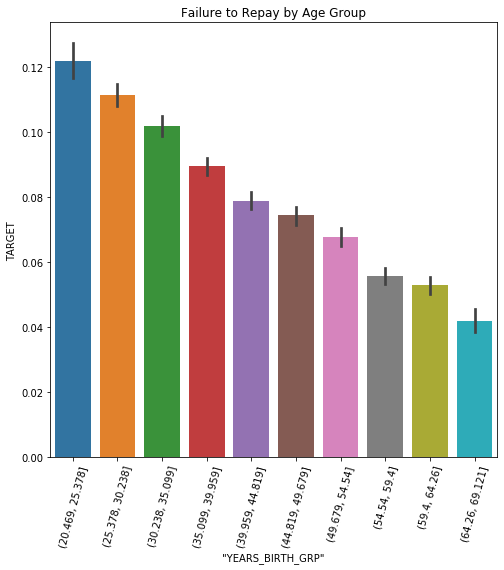

In [15]:
plt.figure(figsize = (8, 8))

# 以年齡區間為 x, target 為 y 繪製 barplot
"""
Your Code Here
"""
px = app_train["YEARS_BIRTH_GRP"]
py = age_data['TARGET']
sns.barplot(px, py)

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('"YEARS_BIRTH_GRP"'); plt.ylabel('TARGET')
plt.title('Failure to Repay by Age Group');